## Imports

In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import xskillscore as xs

import som_analysis
import cluster_analysis
import narm_analysis

## functions

In [ ]:
def add_insetmap(axes_extent, map_extent, lons, lats, temp_data, 
                 vmin, vmax, cmap='coolwarm'):
    
    use_projection = ccrs.Mercator()     # preserve shape well
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
    
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    
    sub_ax.set_extent(map_extent, geodetic)  # map extents
    sub_ax.coastlines(linewidth=0.35, zorder=10)
    
    sub_ax.pcolormesh(lons, lats, temp_data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap=cmap)

    extent_box = sgeom.box(map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none', linewidth=0.05)

In [ ]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month>=mo_init) | (dt_array.month<=mo_end), True, False)

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## open and preprocess data

In [ ]:
# region for clustering
lat0=10; lat1=70; lon0=-150; lon1=-40

# open era5 data and slice
ds_era5 = narm_analysis.era5_z500(lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1)

# era5 anomalies
ds_era5_anom = narm_analysis.era5_climo_wrs(ds_era5, rolling_days=5, variable='clim')

# restructure era5 array for machine learning training (SONDJFM)
ds_era5_anom = ds_era5_anom[get_cold_indx(ds_era5_anom, mo_init=10, mo_end=3),...]
ds_era5_train = ds_era5_anom.stack(flat=('lat','lon')).transpose('time','flat').values

KeyboardInterrupt: 

## pca and kmeans with era5

In [ ]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(ds_era5_train)

# transform era5 data with pca
ds_era5_train = pca_obj.transform(ds_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(ds_era5_train)

print(f'inertia: {k_means.inertia_}')

## load data with lead time bias corrected anomalies

In [ ]:
# era5 data
z500_era5, z500_era5_dt = som_analysis.open_era5_files(
    variable='z500', return_time=True, 
    lat0=lat0,lat1=lat1,lon0=lon0,lon1=lon1,
    leadday0=0,leadday1=42,rolldays=5,)

# cesm data
z500_cesm, z500_cesm_dt = som_analysis.open_cesm_files(
    variable='zg_500', return_time=True, 
    lat0=lat0,lat1=lat1,lon0=lon0,lon1=lon1,
    leadday0=0,leadday1=42,rolldays=5,)

# cesm ensemble data
z500_ensm, z500_ensm_dt, z_ensm = som_analysis.open_cesm_ensembles(
    variable='zg_500', return_time=True, 
    lat0=lat0,lat1=lat1,lon0=lon0,lon1=lon1,
    leadday0=0,leadday1=42,return_ens=True,rolldays=5)

# restructure arrays
z500_standard_era5 = z500_era5.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')
z500_standard_cesm = z500_cesm.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')
z500_standard_ensm = z500_ensm.stack(
    new=('time','ensemble','lead'),flat=('lat','lon')).transpose('new','flat')

## extract cluster labels

(projecting era5 pca and kmeans onto cesm2)

In [ ]:
cluster_era5_evo = cluster_analysis.single_clusters(  z500_standard_era5, k_means, pca_obj, use_pca=True)
cluster_cesm_evo = cluster_analysis.single_clusters(  z500_standard_cesm, k_means, pca_obj, use_pca=True)
cluster_ensm_evo = cluster_analysis.ensemble_clusters(z500_standard_ensm, k_means, pca_obj, use_pca=True)

## weather regime agreement as a function of lead time

In [ ]:
ensm_mode, ensm_count = stats.mode(cluster_ensm_evo[:,:,:], axis=0)

## composites of the weather types/regimes

In [ ]:
### grab cluster indices

z500_era5_tmp_1, z500_era5_tmp_2, z500_era5_tmp_3, z500_era5_tmp_4 = cluster_analysis.composite_clusters_indx(
    z500_standard_era5, k_means, pca_obj, use_pca=True)

z500_cesm_tmp_1, z500_cesm_tmp_2, z500_cesm_tmp_3, z500_cesm_tmp_4 = cluster_analysis.composite_clusters_indx(
    z500_standard_cesm, k_means, pca_obj, use_pca=True)

## outgoing longwave radiation

In [11]:
# era5 data
rlut_era5, _ = som_analysis.open_era5_files(
    variable='ttr', return_time=True, 
    lat0=-10,lat1=10,lon0=30-360,lon1=210-360,
    leadday0=0,leadday1=42,rolldays=5,)

# cesm data
rlut_cesm, _ = som_analysis.open_cesm_files(
    variable='rlut', return_time=True, 
    lat0=-10,lat1=10,lon0=30-360,lon1=210-360,
    leadday0=0,leadday1=42,rolldays=5,)

# restructure data array
rlut_era5_tmp = rlut_era5.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')

rlut_cesm_tmp = rlut_cesm.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')

In [12]:
# extract clusters using indices

rlut_era5_tmp_01 = rlut_era5_tmp.unstack('flat').transpose('new','lat','lon')[z500_era5_tmp_1, :, :]
rlut_era5_tmp_02 = rlut_era5_tmp.unstack('flat').transpose('new','lat','lon')[z500_era5_tmp_2, :, :]
rlut_era5_tmp_03 = rlut_era5_tmp.unstack('flat').transpose('new','lat','lon')[z500_era5_tmp_3, :, :]
rlut_era5_tmp_04 = rlut_era5_tmp.unstack('flat').transpose('new','lat','lon')[z500_era5_tmp_4, :, :]

rlut_cesm_tmp_01 = rlut_cesm_tmp.unstack('flat').transpose('new','lat','lon')[z500_cesm_tmp_1, :, :]
rlut_cesm_tmp_02 = rlut_cesm_tmp.unstack('flat').transpose('new','lat','lon')[z500_cesm_tmp_2, :, :]
rlut_cesm_tmp_03 = rlut_cesm_tmp.unstack('flat').transpose('new','lat','lon')[z500_cesm_tmp_3, :, :]
rlut_cesm_tmp_04 = rlut_cesm_tmp.unstack('flat').transpose('new','lat','lon')[z500_cesm_tmp_4, :, :]

## hovmoller diagram case selection

There are 14 unique forecasts that meet criteria.
Indices of dim_1: 28


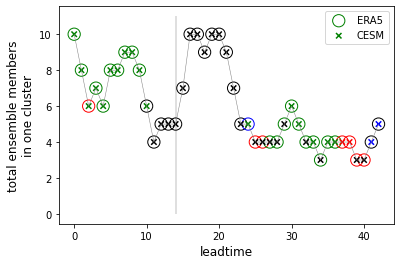

Indices of dim_1: 84


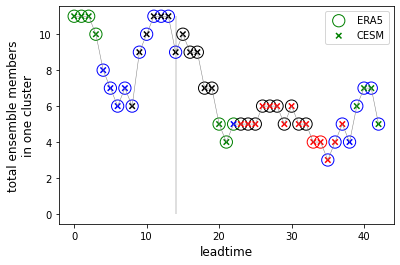

Indices of dim_1: 109


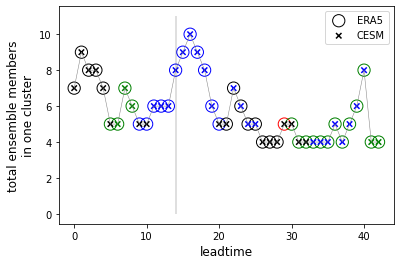

Indices of dim_1: 133


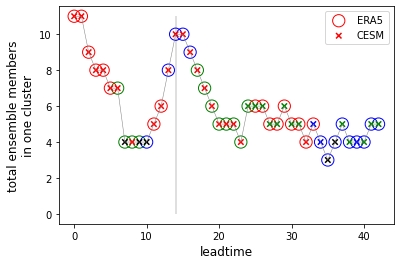

Indices of dim_1: 178


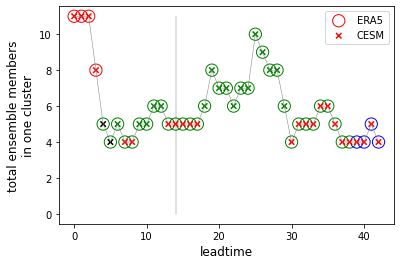

Indices of dim_1: 206


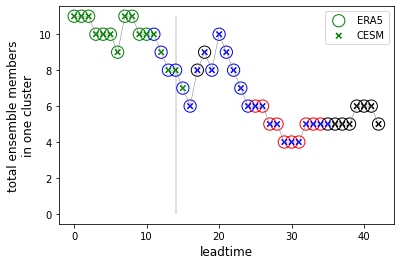

Indices of dim_1: 257


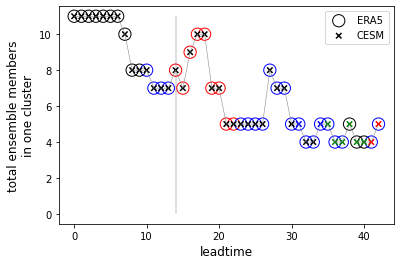

Indices of dim_1: 258


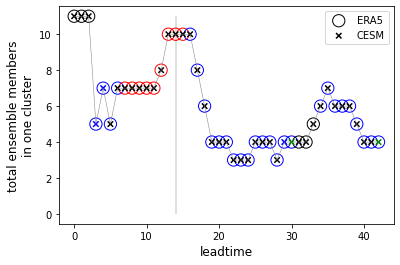

Indices of dim_1: 321


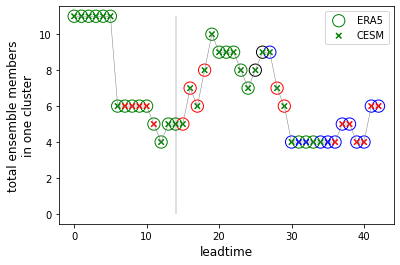

Indices of dim_1: 339


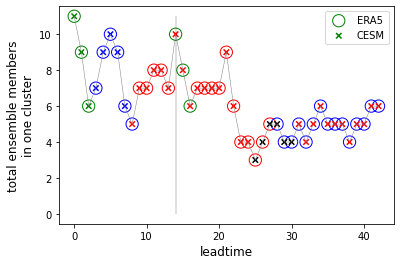

Indices of dim_1: 362


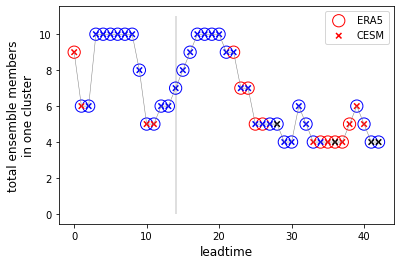

Indices of dim_1: 406


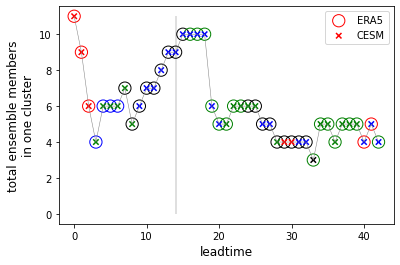

Indices of dim_1: 414


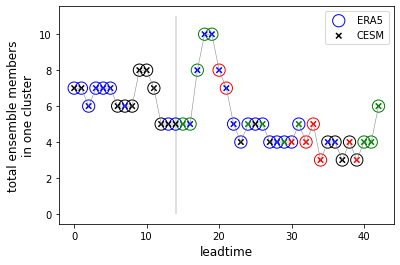

Indices of dim_1: 461


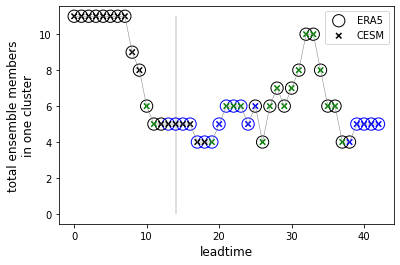

In [53]:
cutoff_day = 14
wr_color = ['k','red','green','blue']

dim_0, dim_1, dim_2 = np.where(ensm_count[:, :, cutoff_day:]>=10)

print(f'There are {np.unique(dim_1).shape[0]} unique forecasts that meet criteria.')
#print('Indices of dim_1:', np.unique(dim_1))

plt.figure(figsize=(6,4))

for dm_ in np.unique(dim_1):
    
    wr_c_list = []
    for i in ensm_mode[0,dm_,:]:
        wr_c_list.append(wr_color[int(i)])
        
    wr_e_list = []
    for i in cluster_era5_evo[0,dm_,:]:
        wr_e_list.append(wr_color[int(i)])
    
    plt.plot(np.arange(0,43,1), ensm_count[0,dm_,:], lw=0.5, c='grey')
    plt.vlines(cutoff_day, 0, 11, colors='k', lw=0.25)
    
    l1 = plt.scatter(np.arange(0,43,1), ensm_count[0,dm_,:], s=150, marker='o', edgecolor=wr_e_list, facecolor='none')
    l2 = plt.scatter(np.arange(0,43,1), ensm_count[0,dm_,:], s=30,  marker='x', c=wr_c_list)
    
    plt.legend([l1,l2],['ERA5','CESM'])
    plt.ylabel('total ensemble members\nin one cluster', fontsize=12)
    plt.xlabel('leadtime', fontsize=12)
    plt.title(print('Indices of dim_1:', dm_))
    plt.show()

## hovmoller diagrams

Phase 1 & 8 - Western Hemisphere And Africa

Phase 2 & 3 - Indian Ocean

Phase 4 & 5 - Maritime Continent

Phase 6 & 7 - Western Pacific.

Currently the signal is a weak one as seen in this phase diagram MJO Phase diagram

When the MJO signal is strong it's amplitude will be greater than 1 and the contour line will be outside the circle. It should be noted that the MJO is an empircal index consisting of the 850 hPa winds, OLR and 200 hPa winds.

MJO passage through phase 6 and 7 is always of global interest as the impact can be of planetary scale. Usually El Ninos are preceded by Westerly Wind Bursts and the forcing factor can be a MJO passage through phase 6 and 7.

One can look at the raw data of the signal here - RMM Index text. This provides the amplitude of the signal as well as the phase of the MJO.

Another version of the same can be seen here - MJO RMM index

In [14]:
mjo_csv = pd.read_csv('/glade/scratch/molina/s2s/MJO_1996-2002.csv')

In [15]:
weights = np.cos(np.deg2rad(rlut_era5_tmp.unstack('flat').lat.values))

In [16]:
cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0.2, 1.0)

In [17]:
square1 = mlines.Line2D([], [], color='grey', marker='s', linestyle='None',
                        markersize=10, label='square1')
square2 = mlines.Line2D([], [], color='slateblue', marker='s', linestyle='None',
                        markersize=10, label='square2')
square3 = mlines.Line2D([], [], color='steelblue', marker='s', linestyle='None',
                        markersize=10, label='square3')
square4 = mlines.Line2D([], [], color='lightgrey', marker='s', linestyle='None',
                        markersize=10, label='square4')

/glade/scratch/molina/ipykernel_241234/2896540964.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


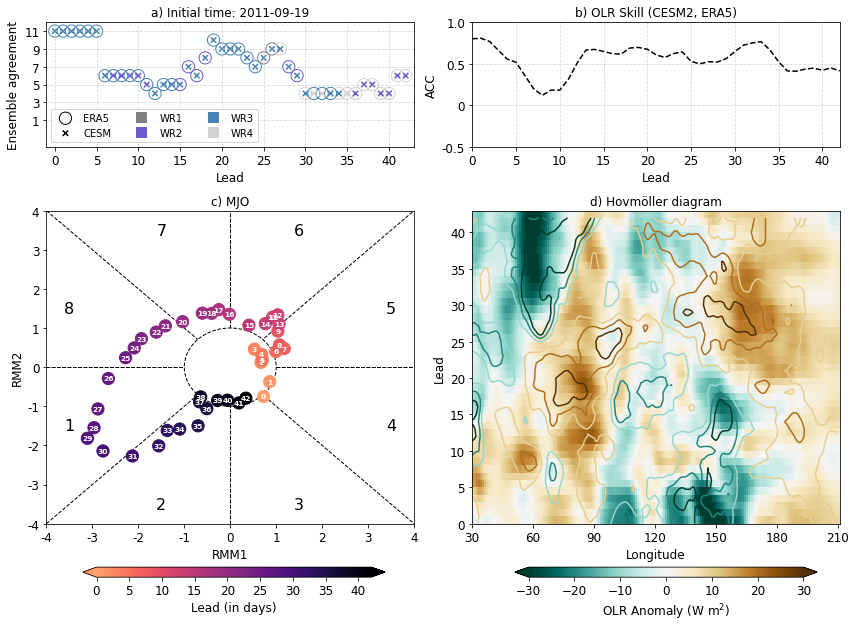

In [54]:
## -- ## -- ## -- ## -- ## --


dm_ = 321

wr_color = ['grey','slateblue','steelblue','lightgrey']


## -- ## -- ## -- ## -- ## --


wr_c_list = []
for i in ensm_mode[0,dm_,:]:
    wr_c_list.append(wr_color[int(i)])

wr_e_list = []
for i in cluster_era5_evo[0,dm_,:]:
    wr_e_list.append(wr_color[int(i)])
    

## --

    
avg_data1 = (
    (-rlut_era5_tmp.unstack('flat').unstack('new').transpose(
        'time','lead','lat','lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat',skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data2 = (
    (rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
        'time','lead','lat','lon').isel(time=dm_) * weights[None, :, None]).sum(
        dim='lat',skipna=True) / np.sum(weights)).rolling(
    lon=3, min_periods=1, center=True).mean()

avg_data1_ = avg_data1.values
avg_data2_ = avg_data2.values


## --


mjo_phase_ = np.zeros((43))
mjo_rmm1_  = np.zeros((43))
mjo_rmm2_  = np.zeros((43))
mjo_amp_   = np.zeros((43))

for i in range(43):

    tmp_date_ = pd.to_datetime(avg_data2.time.values) + timedelta(days=i)
    
    tmp_mjo_ = mjo_csv[(mjo_csv['year']==tmp_date_.year)&(
        mjo_csv['month']==tmp_date_.month)&(mjo_csv['day']==tmp_date_.day)]
    
    mjo_phase_[i] = tmp_mjo_['phase'].values[0]
    mjo_rmm1_[i]  = tmp_mjo_['RMM1'].values[0]
    mjo_rmm2_[i]  = tmp_mjo_['RMM2'].values[0]
    mjo_amp_[i]   = tmp_mjo_['amplitude'].values[0]
    
    
## --


mjo_skill = []
for pl in range(43):
    mjo_skill.append(stats.pearsonr(avg_data1[pl,:],avg_data2[pl,:])[0])


## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid(shape=(3, 2), loc=(0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(shape=(3, 2), loc=(0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid(shape=(3, 2), loc=(1, 0), rowspan=2, colspan=1)
ax4 = plt.subplot2grid(shape=(3, 2), loc=(1, 1), rowspan=2, colspan=1)


## -- 


l1 = ax1.scatter(
    np.arange(0,43,1), ensm_count[0,dm_,:], s=150, marker='o', edgecolor=wr_e_list, facecolor='none')
l2 = ax1.scatter(
    np.arange(0,43,1), ensm_count[0,dm_,:], s=30,  marker='x', c=wr_c_list)

leg = ax1.legend([l1,l2,square1,square2,square3,square4],
                 ['ERA5','CESM','WR1','WR2','WR3','WR4'],
                 fancybox=True,ncol=3,loc='lower left',fontsize=10)

leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_edgecolor('k')

ax1.set_ylabel('Ensemble agreement', fontsize=12)
ax1.set_xlabel('Lead', fontsize=12)

ax1.set_xticks(np.arange(0,43,1)[::5])
ax1.set_xticklabels(np.arange(0,43,1)[::5],fontsize=12)
ax1.set_yticks(np.arange(1,12,1)[::2])
ax1.set_yticklabels(np.arange(1,12,1)[::2],fontsize=12)

ax1.margins(x=0,y=0)
ax1.set_xlim([-1,43])
ax1.set_ylim([-2,12])
ax1.grid(ls='--',alpha=0.5)

ax1.set_title(
    'a) Initial time: '+pd.to_datetime(avg_data1.time.values).strftime('%Y-%m-%d'),
    fontsize=12)


## --


ax2.plot(np.arange(0,43,1), mjo_skill, c='k', ls='--', lw=1.5)

ax2.set_title('b) OLR Skill (CESM2, ERA5)')

ax2.set_xlim([0,42])
ax2.set_xlabel('Lead',fontsize=12)
ax2.set_xticks([0,5,10,15,20,25,30,35,40])
ax2.set_xticklabels([0,5,10,15,20,25,30,35,40],fontsize=12)

ax2.set_ylim([-0.5,1.0])
ax2.set_ylabel('ACC',fontsize=12)
ax2.set_yticks([-0.5,0,0.5,1.0])
ax2.set_yticklabels([-0.5,0,0.5,1.0],fontsize=12)

ax2.margins(x=0,y=0)
ax2.grid(alpha=0.5,ls='--')


## --


cs3 = ax3.scatter(
    mjo_rmm1_[::], mjo_rmm2_[::], c=np.arange(0,43,1), vmin=0, vmax=42,
    cmap=new_cmap, zorder=8, s=150)

for i in range(0,43)[::]:
    ax3.annotate(
        int(i), xy=(mjo_rmm1_[i], mjo_rmm2_[i]), color='w', fontweight='bold', 
        fontsize=7.5, zorder=8, horizontalalignment='center', verticalalignment='center')

ax3.hlines(y=[0,0], xmin=-4, xmax=-1, lw=1.0, ls='--', color='k')
ax3.hlines(y=[0,0], xmin=1, xmax=4, lw=1.0, ls='--', color='k')
ax3.vlines(x=[0,0], ymin=-4, ymax=-1, lw=1.0, ls='--', color='k')
ax3.vlines(x=[0,0], ymin=1, ymax=4, lw=1.0, ls='--', color='k')

ax3.plot(np.arange(-4,5,1), np.flip(np.arange(-4,5,1)), lw=1.0, ls='--', color='k')
ax3.plot(np.arange(-4,5,1), np.arange(-4,5,1), lw=1.0, ls='--', color='k')

Drawing_uncolored_circle = plt.Circle(
    xy=(0.,0.), radius=1.0, zorder=5, fill=True, edgecolor='k', ls='--', lw=1.0, facecolor='w')

ax3.add_artist(Drawing_uncolored_circle)

ax3.set_xlim(-4,4)
ax3.set_ylim(-4,4)

ax3.annotate('1', xy=(-3.5, -1.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')
ax3.annotate('2', xy=(-1.5, -3.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')
ax3.annotate('3', xy=(1.5, -3.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')
ax3.annotate('4', xy=(3.5, -1.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')
ax3.annotate('5', xy=(3.5, 1.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')
ax3.annotate('6', xy=(1.5, 3.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')
ax3.annotate('7', xy=(-1.5, 3.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')
ax3.annotate('8', xy=(-3.5, 1.5), color='k', fontsize=16, zorder=120, 
            horizontalalignment='center', verticalalignment='center')

ax3.set_title('c) MJO', fontsize=12)

ax3.set_xticks([-4,-3,-2,-1,0,1,2,3,4])
ax3.set_xticklabels([-4,-3,-2,-1,0,1,2,3,4], fontsize=12)
ax3.set_xlabel('RMM1',fontsize=12)

ax3.set_yticks([-4,-3,-2,-1,0,1,2,3,4])
ax3.set_yticklabels([-4,-3,-2,-1,0,1,2,3,4], fontsize=12)
ax3.set_ylabel('RMM2',fontsize=12)

ax3.margins(x=0,y=0)


## --


cbar_ax = fig.add_axes([0.1, -0.01, 0.35, 0.0175])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=np.arange(0,43,1)[::5], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Lead (in days)', fontsize=12)


## --


ax4.set_title('d) Hovmöller diagram',fontsize=12)

ax4.contour(avg_data1_,cmap='BrBG_r',vmin=-30,vmax=30,levels=[-30,-20,-10,10,20,30])
cs4 = ax4.pcolormesh(avg_data2_,cmap='BrBG_r',vmin=-30,vmax=30)

ax4.set_xlabel('Longitude',fontsize=12)
ax4.set_ylabel('Lead',fontsize=12)

ax4.set_yticks(np.arange(0,avg_data1_.shape[0],1)[::5])
ax4.set_yticklabels(np.arange(0,avg_data1_.shape[0],1)[::5],fontsize=12)

ax4.set_xticks(np.arange(0,avg_data1_.shape[1],1)[::30])
ax4.set_xticklabels(avg_data1.lon.values.astype(int)[::30],fontsize=12)
ax4.margins(x=0,y=0)


## --


cbar_ax = fig.add_axes([0.6, -0.01, 0.35, 0.0175])

ticks_1 = [-30,-20,-10,0,10,20,30]
cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'OLR Anomaly (W m$^2$)', fontsize=12)


## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --


plt.tight_layout()
#plt.savefig(f"fig_case{dm_}.png", bbox_inches='tight', dpi=500)
plt.show()


## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## -- ## --